## Here we'll take a look at the techniques to deal with with imbalanced data

**A dataset is imbalanced if the classification categories are not approximately equally represented. Often real-world data sets are predominately composed of normal examples with only a small percentage of abnormal or interesting examples. It is also the case that the cost of misclassifying an abnormal (interesting) example as a normal example is often much higher than the cost of the reverse error.** 

***The tactics to overcome imbalance are :***


    

1.   **Getting more data**  : It is impossible in this case but if we get more data than we can surely get more entries with minority class
 
2.   **Changing the performance matric**  :Accuracy is not the metric to use when working with an imbalanced dataset because even if we classify minority class entries as majority class entries,then also we'll get a very good accuracy.We'll see in this notebook how this happens.
      *These are the measures which can giver better results*\n
     -  Confusion Matrix: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
     - Precision: A measure of a classifiers exactness.
     - Recall: A measure of a classifiers completeness
     - F1 Score (or F-score): A weighted average of precision and recall.
3.   **Resampling the dataset**   :  We can change the dataset that you use to build your predictive model to have more balanced data.

       This change is called sampling your dataset and there are three main methods that we can use to even-up the classes:

       - *OverSampling*  : We can add copies of instances from the under-represented class.It generally leads to overfitting and one special is taken while preprocessing i.e separating the validation set before splitting into train and test set because we may encouter the duplicate entries on whom the model has been fitted.
       -  *UnderSampling*:  We can delete instances from the over-represented class and it leads to underfitting because we are losing our important feature and entries.
       -   *SMOTE*       :   We propose an over-sampling approach in which the minority class is over-sampled by creating synthetic examples rather than by over-sampling with replacement. This approach is inspired by a technique that proved successful in handwritten character recognition.
            We generate synthetic examples in a less application-specific manner, by operating in feature space rather than data space. The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors. Depending upon the amount of over-sampling required, neighbors from the k nearest neighbors are randomly chosen.

4.  **Try Penalized Models**     :   Penalized classification imposes an additional cost on the model for making classification mistakes on the minority class during training. These penalties can bias the model to pay more attention to the minority class.


In [1]:
# Importing Packages


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors.kde import KernelDensity
from scipy import stats
from sklearn import linear_model
from imblearn.over_sampling import     SMOTE
from collections import Counter
%matplotlib inline

In [2]:
df=pd.read_csv("../input/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


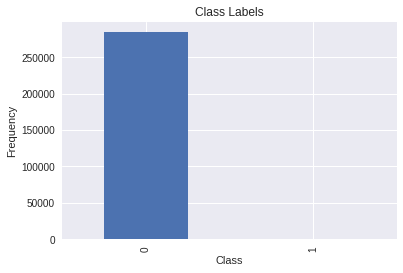

In [3]:
# Finding the count of classes

class_labels=pd.value_counts(df['Class'],sort=True).sort_index()
class_labels.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Labels")

**As we can see that the data is highly imbalanced.The minority class is not even 10% of the majority class.Thus even if we classify minority class wrongly,we'll get good accuracy**

In [4]:
# We don't need "Time" as it is redundant feature so we can remove it.
df=df.drop("Time",axis=1)

***

Now,as discussed above validation set is separated before splitting into "Train" and "Test" set because we may encouter the duplicate entries on whom the model has been fitted.Thus the validation score may get affected and we won't get real results as it will be overfitted. It makes no sense to create instances based on our current minority class and then exclude an instance for validation, pretending we didn’t generate it using data that is still in the training set. ***

In [5]:
# Separating Validation Set from the train and test set before fitting the model

validation_Set=df.sample(frac=0.3,random_state=42)
df=pd.concat([df,validation_Set])
df=df.drop_duplicates(keep=False)
V_y=validation_Set['Class']
V_x=validation_Set.drop('Class',axis=1)
V_x.shape

(85442, 29)

In [6]:
# Creating independent and dependant variable.

X=df.drop("Class",axis=1)
target=df['Class']

In [7]:
# Splitting into train and test samples.

X_train,X_test,y_train,y_test=train_test_split(X,target,test_size=0.25,random_state=42)


*Here we are evaluating the model on the basis of their "Train Score","Test Score","Net score on the entire dataset" as well as the "Cross-validation score".The idea is to check whether the model is overfitted or not.*

In [8]:
# Function to evaluate the model

def evaluate(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    train_score=model.score(X_train,y_train)
    test_score=model.score(X_test,y_test)
    overall_score=model.score(X,target)
    val_score=cross_val_score(model,V_x,V_y,cv=5)
    print('{}'.format(train_score)  +   "    is the train score")
    print('{}'.format(test_score)  +   "    is the test score")
    print('{}'.format(overall_score)  +   "    is the net score")
    print('{}'.format(val_score.mean())  +   "    is the cross validation score score")

In [9]:
# Fitting Logistic Regression Model

l_reg=linear_model.LogisticRegression(C=1e-3)
evaluate(l_reg,X_train,y_train,X_test,y_test)

0.9989089040469101    is the train score
0.9986907125058073    is the test score
0.9988543552976828    is the net score
0.9987008810483384    is the cross validation score score


As we can see that we are getting huge accuracy even after having sparse samples of minority class.This clearly shows that majority class dominates and also we can't judge whether our model provides right fit to the problem or not. 

In [10]:
temp=X.drop('Amount',axis=1)

## Outliers Analysis

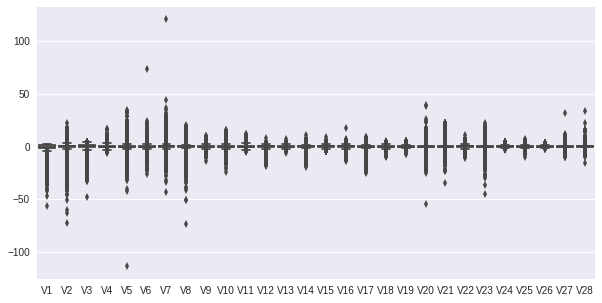

In [11]:
# Checking the outliers by plotting boxplot of the columns of the data

plt.figure(figsize=(10,5))
sns.boxplot(data=temp)

*As we can see that the data contains a large no of outliers in each column.But we can't remove them as we might end up shrinking the size of minority class and thus our model will become extremely overfitting*

**Lets take a look at the histogram of columns of the data and analyse the skewness of the dataset**

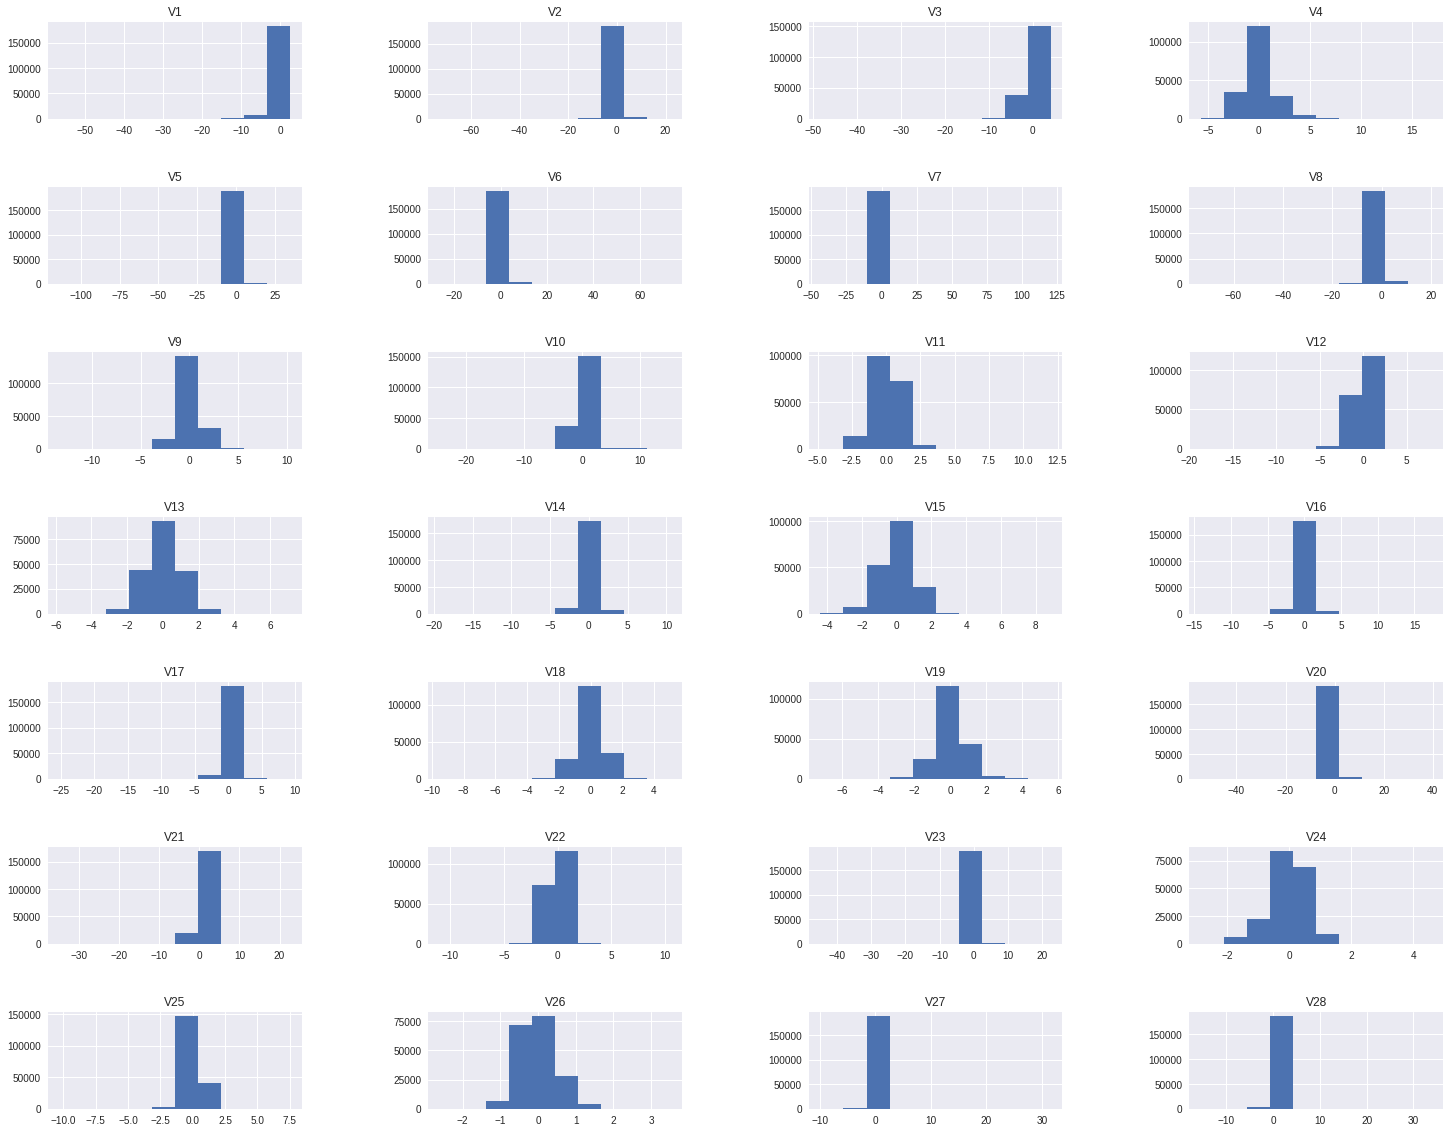

In [12]:
fig,ax=plt.subplots(7,4,figsize=(25,20))
num=df.columns
count=0
for i in range(7):
    for j in range(4):
        ax[i,j].hist(np.array(df[num[count]]))
        ax[i,j].set_title(num[count])
        count+=1
plt.subplots_adjust(wspace=0.5, hspace=0.7)

## SMOTE

*** The synthetic examples cause the classifier to create larger and less specific decision regions, rather than smaller and more specific regions. More general regions are now learned for the minority class samples rather than those being subsumed by the majority class samples around them. The effect is that decision trees generalize better.Here WE HAD 141809 SAMPLES TO BELONG FROM MAJORITY CLASS  and 250 samples from minority class AND AFTER SMOTE we have equal amount of both classes and main part is that the entries are not duplicate as the case with over-sampling.Hence the results will be more generalized.***

In [13]:
sm = SMOTE(random_state=42)
X_res1, y_res1 = sm.fit_sample(X_train,y_train)
X_res2,y_res2=sm.fit_sample(X_test,y_test)
print('{}'.format(Counter(y_res1)))

Counter({0: 141809, 1: 141809})


In [14]:
l_reg=linear_model.LogisticRegression(C=1e-3)
evaluate(l_reg,X_res1,y_res1,X_res2,y_res2)

0.9627773977674196    is the train score
0.9358366828855511    is the test score
0.9832271280218359    is the net score
0.9987008810483384    is the cross validation score score


***As stated in point no. 4,adding penalised models can improve the performance of the training model,thus lets analyze Sparsity and score of the model with various penalties***

In [15]:
for i, C in enumerate((100, 1, 0.01,0.001)):
    # turn down tolerance for short training time
    clf_l1_LR = linear_model.LogisticRegression(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = linear_model.LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X_train,y_train)
    clf_l2_LR.fit(X_train,y_train)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.2f" % C)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X_test,y_test))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X_test,y_test))

C=100.00
Sparsity with L1 penalty: 0.00%
score with L1 penalty: 0.9988
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.9988
C=1.00
Sparsity with L1 penalty: 3.45%
score with L1 penalty: 0.9988
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.9989
C=0.01
Sparsity with L1 penalty: 79.31%
score with L1 penalty: 0.9988
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.9989
C=0.00
Sparsity with L1 penalty: 82.76%
score with L1 penalty: 0.9983
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.9987


### Task for future : Writing step by step code of SMOTE and comparing performances of different classifiers on imbalaced dataset

For any suggestion or advise please Comment.
   Thanks